In [1]:
import os
import warnings
from datetime import datetime, timedelta
from math import ceil
from typing import List, Tuple

import akshare as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyecharts
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as fn
from numpy import array, ndarray
from pandas import DataFrame
from pyecharts import options as opts
from pyecharts.charts import Bar, Line
from pyecharts.globals import ThemeType
from pyecharts.options import TooltipOpts
from sklearn.preprocessing import MinMaxScaler
from torch import FloatTensor, Tensor
from torch.nn import (ELU, LSTM, AvgPool1d, BatchNorm1d, BatchNorm2d, Conv1d,
                      Conv2d, Dropout, Linear, Module, MSELoss,
                      MultiheadAttention, ReLU, Sigmoid)
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset

from util import get_device, load_stock_data

os.chdir('d:/workspace/transformer-quant')

warnings.simplefilter(action="ignore", category=FutureWarning)

c:\dev\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# hs300 :DataFrame = load_stock_data('sh000300')
data: DataFrame = load_stock_data('sh000905')

DATE = 'date'
OPEN = 'open'
HIGH = 'high'
LOW = 'low'
CLOSE = 'close'
VOLUME = 'volume'

data

,date,open,high,low,close,volume
0,2005-01-04,996.682,996.682,984.795,986.927,232376203
1,2005-01-05,986.570,1008.855,985.677,1003.633,348610113
2,2005-01-06,1003.490,1003.490,990.792,994.595,293390559
3,2005-01-07,993.434,1009.000,990.446,997.606,339162698
4,2005-01-10,996.928,1006.457,993.123,1006.337,294940533
...,...,...,...,...,...,...
4358,2022-12-09,6185.794,6213.517,6159.504,6192.301,16780682500
4359,2022-12-12,6181.244,6182.078,6146.255,6154.809,13409831000
4360,2022-12-13,6153.738,6154.297,6113.414,6121.662,10485751500
4361,2022-12-14,6122.432,6139.738,6084.080,6096.386,9508991600


In [3]:
data_valid = data[data[VOLUME] != 0]
data_valid

,date,open,high,low,close,volume
0,2005-01-04,996.682,996.682,984.795,986.927,232376203
1,2005-01-05,986.570,1008.855,985.677,1003.633,348610113
2,2005-01-06,1003.490,1003.490,990.792,994.595,293390559
3,2005-01-07,993.434,1009.000,990.446,997.606,339162698
4,2005-01-10,996.928,1006.457,993.123,1006.337,294940533
...,...,...,...,...,...,...
4358,2022-12-09,6185.794,6213.517,6159.504,6192.301,16780682500
4359,2022-12-12,6181.244,6182.078,6146.255,6154.809,13409831000
4360,2022-12-13,6153.738,6154.297,6113.414,6121.662,10485751500
4361,2022-12-14,6122.432,6139.738,6084.080,6096.386,9508991600


In [4]:
line = Line(opts.InitOpts(theme=ThemeType.LIGHT, bg_color='white')) \
    .set_global_opts(tooltip_opts=TooltipOpts(trigger='axis')) \
    .add_xaxis(data_valid[DATE].tolist()) \
    .add_yaxis('收盘价',  data_valid[CLOSE].tolist())

line.render_notebook()    

<AxesSubplot: xlabel='date', ylabel='close'>

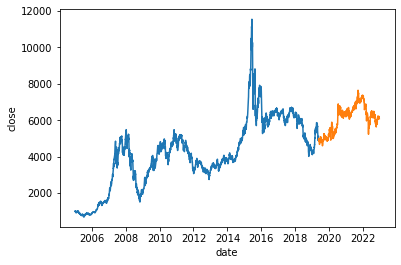

In [5]:
# 分割数据集
seq_len = len(data_valid)
train_data_len = int(seq_len * 0.8)

train_data = data_valid[1:train_data_len]
test_data = data_valid[train_data_len:-1]



sb.lineplot(x=train_data[DATE], y=train_data[CLOSE])
sb.lineplot(x=test_data[DATE], y=test_data[CLOSE])

In [6]:
# 归一化

max_volume = max(train_data[VOLUME])
min_volume = min(train_data[VOLUME])

VOLUME_SCALED = 'volume_scaled'
train_data[VOLUME_SCALED] = (train_data[VOLUME] - min_volume ) / (max_volume - min_volume)
test_data[VOLUME_SCALED] = (test_data[VOLUME] - min_volume ) / (max_volume - min_volume)

test_data


C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\1977998752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[VOLUME_SCALED] = (train_data[VOLUME] - min_volume ) / (max_volume - min_volume)
C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\1977998752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[VOLUME_SCALED] = (test_data[VOLUME] - min_volume ) / (max_volume - min_volume)


,date,open,high,low,close,volume,volume_scaled
3490,2019-05-17,5112.241,5116.993,4923.673,4942.579,11907121300,0.410747
3491,2019-05-20,4937.177,4947.746,4835.809,4923.559,9568649700,0.328042
3492,2019-05-21,4917.342,5026.284,4904.823,5009.873,10083707300,0.346258
3493,2019-05-22,5002.160,5018.109,4941.010,4976.393,9409270900,0.322405
3494,2019-05-23,4955.252,4957.986,4860.188,4872.920,9056368100,0.309924
...,...,...,...,...,...,...,...
4357,2022-12-08,6199.164,6206.141,6168.781,6186.284,13105132500,0.453118
4358,2022-12-09,6185.794,6213.517,6159.504,6192.301,16780682500,0.583112
4359,2022-12-12,6181.244,6182.078,6146.255,6154.809,13409831000,0.463894
4360,2022-12-13,6153.738,6154.297,6113.414,6121.662,10485751500,0.360477


In [7]:
# 添加增长率
CLOSE_GROWTH_RATE = 'close_growth_rate'
OPEN_GROWTH_RATE = 'open_growth_rate'
HIGH_GROWTH_RATE = 'high_growth_rate'
LOW_GROWTH_RATE = 'low_growth_rate'

data[CLOSE_GROWTH_RATE] = data[CLOSE].pct_change()
data[OPEN_GROWTH_RATE] = data[OPEN].pct_change()
data[HIGH_GROWTH_RATE] = data[HIGH].pct_change()
data[LOW_GROWTH_RATE] = data[LOW].pct_change()

train_data[CLOSE_GROWTH_RATE] = data[CLOSE_GROWTH_RATE][train_data.index]
train_data[OPEN_GROWTH_RATE] = data[OPEN_GROWTH_RATE][train_data.index]
train_data[HIGH_GROWTH_RATE] = data[HIGH_GROWTH_RATE][train_data.index]
train_data[LOW_GROWTH_RATE] = data[LOW_GROWTH_RATE][train_data.index]

test_data[CLOSE_GROWTH_RATE] = data[CLOSE_GROWTH_RATE][test_data.index]
test_data[OPEN_GROWTH_RATE] = data[OPEN_GROWTH_RATE][test_data.index]
test_data[HIGH_GROWTH_RATE] = data[HIGH_GROWTH_RATE][test_data.index]
test_data[LOW_GROWTH_RATE] = data[LOW_GROWTH_RATE][test_data.index]

print(train_data.head(6))


embed_dim = 5
windows_size = 30

train_x = array([train_data[CLOSE_GROWTH_RATE], train_data[OPEN_GROWTH_RATE], train_data[HIGH_GROWTH_RATE], train_data[LOW_GROWTH_RATE], train_data[VOLUME_SCALED]]).reshape((-1, embed_dim))
train_x = array([train_x[i: i + windows_size] for i in range(len(train_data) - windows_size)])
print(train_x.shape)
train_y = array(data[CLOSE_GROWTH_RATE].shift(-1)[train_data.index])[windows_size:].reshape((-1, 1))
print(train_y, train_y.shape)

test_x = array([test_data[CLOSE_GROWTH_RATE], test_data[OPEN_GROWTH_RATE], test_data[HIGH_GROWTH_RATE], test_data[LOW_GROWTH_RATE], test_data[VOLUME_SCALED]]).reshape((-1, embed_dim))
test_x = array([test_x[i: i + windows_size] for i in range(len(test_data) - windows_size)])
test_y = array(data[CLOSE_GROWTH_RATE].shift(-1)[test_data.index])[windows_size:].reshape((-1, 1))


class NdarrayDataset(Dataset):
    def __init__(self, x: ndarray, y: ndarray) -> None:
        self.x, self.y = x, y

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> Tuple[ndarray, ndarray]:
        return self.x[idx], self.y[idx]


train_dataset = NdarrayDataset(train_x, train_y)
test_dataset = NdarrayDataset(test_x, test_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[CLOSE_GROWTH_RATE] = data[CLOSE_GROWTH_RATE][train_data.index]
C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[OPEN_GROWTH_RATE] = data[OPEN_GROWTH_RATE][train_data.index]
C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy o

         date      open      high      low     close     volume  \
1  2005-01-05   986.570  1008.855  985.677  1003.633  348610113   
2  2005-01-06  1003.490  1003.490  990.792   994.595  293390559   
3  2005-01-07   993.434  1009.000  990.446   997.606  339162698   
4  2005-01-10   996.928  1006.457  993.123  1006.337  294940533   
5  2005-01-11  1006.211  1009.501  999.860  1008.343  313611521   
6  2005-01-12  1008.010  1008.743  998.361  1008.620  319639380   

   volume_scaled  close_growth_rate  open_growth_rate  high_growth_rate  \
1       0.001953           0.016927         -0.010146          0.012214   
2       0.000000          -0.009005          0.017150         -0.005318   
3       0.001619           0.003027         -0.010021          0.005491   
4       0.000055           0.008752          0.003517         -0.002520   
5       0.000715           0.001993          0.009312          0.003024   
6       0.000928           0.000275          0.001788         -0.000751   

   l

C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[OPEN_GROWTH_RATE] = data[OPEN_GROWTH_RATE][test_data.index]
C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[HIGH_GROWTH_RATE] = data[HIGH_GROWTH_RATE][test_data.index]
C:\Users\fansila\AppData\Local\Temp\ipykernel_21312\4253618529.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

0 tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(9.0434e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(7.9877e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 0, total_loss_avg 0.007739756256341934
0 tensor(4.8017e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(4.3529e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(4.3787e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1, total_loss_avg 0.001391568686813116
0 tensor(3.5185e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(4.3564e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(3.7423e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2, total_loss_avg 0.001018246286548674
0 tensor(2.8187e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(2.5093e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(2.3692e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 3, total_loss_avg 0.0008398268255405128
0 tensor(2.6988e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 te

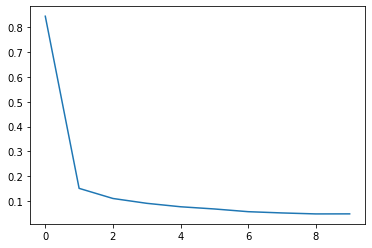

==========test==========
test total avg loss: 0.00018024981545750052
0.505938242280285


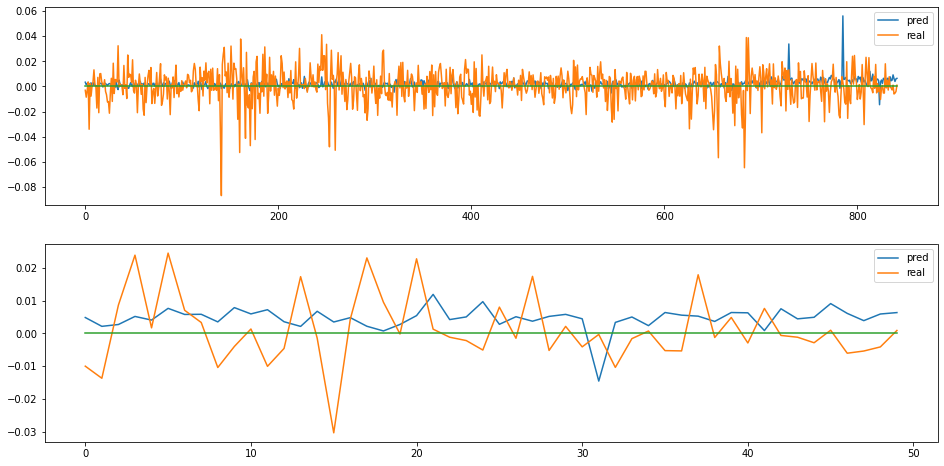

In [8]:
device = get_device()

class TransformerEncoderBlock(Module):
    def __init__(self, seq_len: int, embed_dim: int, num_heads: int, dropout: float) -> None:
        super().__init__()
        self.bn = BatchNorm1d(num_features=seq_len)
        self.multi_head_attention = MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.dropout = Dropout(dropout)

        self.bn1 = BatchNorm1d(num_features=seq_len)
        self.conv1 = Conv1d(in_channels=seq_len, kernel_size=1, out_channels=seq_len)
        self.relu1 = ReLU()
        self.dropout1 = Dropout(dropout)

        self.conv2 = Conv1d(in_channels=seq_len, kernel_size=1, out_channels=seq_len)

    def forward(self, x: Tensor) -> Tensor:
        x0 = x

        x = self.bn(x)
        x = self.multi_head_attention(x, x, x)[0]
        x = self.dropout(x)

        res = x + x0

        x = self.bn1(res)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)

        return x + res


class Time2Vector(Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features - 1))
        self.b = nn.parameter.Parameter(torch.randn(1, out_features - 1))
        self.f = torch.sin

    def forward(self, x:Tensor) -> Tensor:
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        w = self.w.repeat(batch_size, 1, 1)
        b = self.b.repeat(batch_size, seq_len, 1)
        v1 = torch.bmm(x, w) + b

        w0 = self.w0.repeat(batch_size, 1, 1)
        b0 = self.b0.repeat(batch_size, seq_len, 1)
        v2 = self.f(torch.bmm(x, w0)) + self.b0

        return torch.cat([v1, v2], dim=2)


class Model(Module):
    def __init__(self, num_transformer_blocks: int, seq_len:int, embed_dim: int, num_heads: int, dropout:float, t2v_dim: int) -> None:
        super().__init__()
        self.time2vector = Time2Vector(embed_dim, t2v_dim)
        embed_dim += t2v_dim
        self.transformer_blocks = [TransformerEncoderBlock(seq_len=seq_len, embed_dim=embed_dim, num_heads=num_heads, dropout=dropout).to(device)
        for _ in range(num_transformer_blocks)]

        self.avg_pool = AvgPool1d(kernel_size=1)

        self.linear1 = Linear(in_features=seq_len * embed_dim, out_features=32)
        self.relu1 = ReLU()
        self.dropout1 = Dropout(dropout)

        self.linear2 = Linear(in_features=32, out_features=1)

    def forward(self, x: Tensor) -> Tensor:
        t2v = self.time2vector(x)
        x = torch.cat([x, t2v], dim=2)

        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.avg_pool(x)

        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        return x


def train_model(
    model: Module,
    train_dataloader: DataLoader,
    epoch_num: int,
    criterion: Module,
    optimizer: Optimizer
) -> Tuple[List]:
    model.train()
    loss_list = []
    for epoch in range(epoch_num):
        total_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            x, y = x.float().to(device), y.float().to(device)
            output = model(x)
            optimizer.zero_grad()

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            if (i % 50 == 0):
                print(i, loss/x.shape[0])
            total_loss += loss

        loss_list.append(total_loss.item())
        print(f'epoch {epoch}, total_loss_avg {total_loss/len(train_dataloader)}')
    return loss_list


def test_model(
    model: Module,
    test_dataloader: DataLoader,
) -> Tuple[List]:
    model.eval()
    res_list = []
    total_loss = 0
    for i, (x, y) in enumerate(test_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        output = model(x)
        loss = criterion(output, y)
        total_loss += loss
        for o in output.reshape((-1,)).tolist():
            res_list.append(o)
    print(f'test total avg loss: {total_loss/len(test_dataloader)}')
    return res_list


model = Model(num_transformer_blocks=3, seq_len=windows_size, embed_dim=embed_dim, num_heads=2, dropout=0.1, t2v_dim=3).to(device)
criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epoch_num = 10
loss_list = train_model(model, train_dataloader, epoch_num, criterion, optimizer)
sb.lineplot(range(len(loss_list)), loss_list)
plt.show()


print('='*10 + 'test' + '='*10)


res_list = test_model(model, test_dataloader)
test_y_list = test_y.reshape(-1,)

counter = 0
for i in range(len(test_y_list)):
    if (test_y_list[i] > 0 and res_list[i] > 0) or (test_y_list[i] < 0 and res_list[i] < 0):
        counter += 1
print(counter / len(test_y_list))


fig = plt.figure(figsize=(16,8))
fig.add_subplot(2, 1, 1)
sb.lineplot(range(len(res_list)), res_list)
sb.lineplot(range(len(test_y_list)), test_y_list)
sb.lineplot(range(len(test_y_list)), [0]*len(test_y_list))
plt.legend(labels=['pred', 'real'])
fig.add_subplot(2, 1, 2)
sb.lineplot(range(50), res_list[-50:],)
sb.lineplot(range(50), test_y.reshape(-1,)[-50:],)
sb.lineplot(range(50), [0]*50)
plt.legend(labels=['pred', 'real'])

0 tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(4.5855e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(3.0792e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 0, total_loss_avg 0.003999586217105389
0 tensor(2.8540e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(4.3914e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(3.3590e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1, total_loss_avg 0.0011593204690143466
0 tensor(3.9248e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(2.0748e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(1.7118e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2, total_loss_avg 0.000831778219435364
0 tensor(2.2847e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(1.2459e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(1.0136e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 3, total_loss_avg 0.0006531262188218534
0 tensor(1.0190e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 t

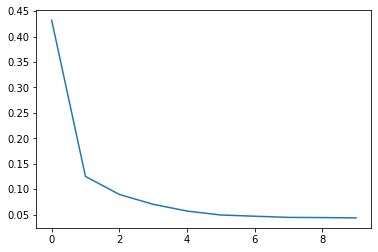

==========test==========
test total avg loss: 0.00022420148889068514
0.5380047505938242


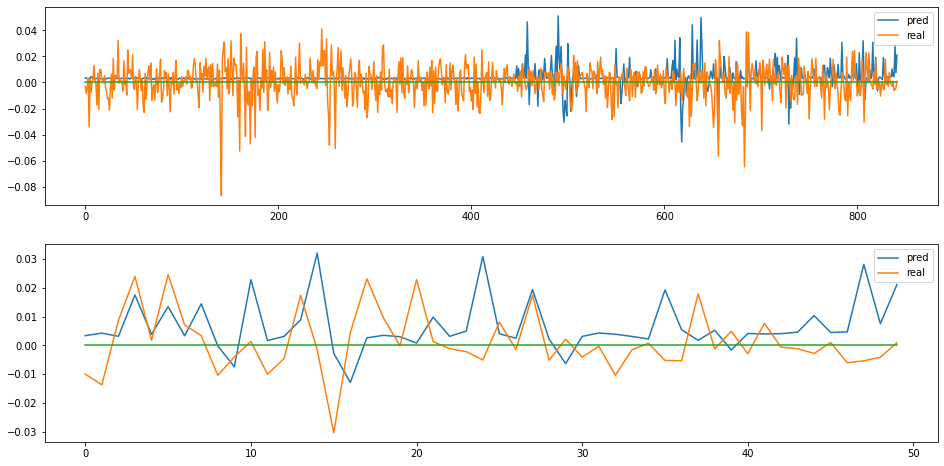

In [10]:
## 添加均线

MA30 = 'MA30'
MA30_SCALED = 'MA30_scaled'
MA10_SCALED = 'MA10_scaled'
MA5_SCALED = 'MA5_scaled'

data_pre_30 = data[CLOSE].rolling(30)
data_pre_10 = data[CLOSE].rolling(10)
data_pre_5 = data[CLOSE].rolling(5)
data[MA30_SCALED] = (data_pre_30.mean() - data_pre_30.min()) / (data_pre_30.max() - data_pre_30.min())
data[MA10_SCALED] = (data_pre_10.mean() - data_pre_10.min()) / (data_pre_10.max() - data_pre_10.min())
data[MA5_SCALED] = (data_pre_5.mean() - data_pre_5.min()) / (data_pre_5.max() - data_pre_5.min())

train_data[MA30_SCALED] = data[MA30_SCALED][train_data.index]
train_data[MA10_SCALED] = data[MA10_SCALED][train_data.index]
train_data[MA5_SCALED] = data[MA5_SCALED][train_data.index]
train_data = train_data.dropna()
train_data.head()

test_data[MA30_SCALED] = data[MA30_SCALED][test_data.index]
test_data[MA10_SCALED] = data[MA10_SCALED][test_data.index]
test_data[MA5_SCALED] = data[MA5_SCALED][test_data.index]
test_data.head()

embed_dim = 8
windows_size = 30

train_x = array([train_data[CLOSE_GROWTH_RATE], train_data[OPEN_GROWTH_RATE], train_data[HIGH_GROWTH_RATE], train_data[LOW_GROWTH_RATE], train_data[VOLUME_SCALED], train_data[MA30_SCALED], train_data[MA10_SCALED], train_data[MA5_SCALED]]).reshape((-1, embed_dim))
train_x = array([train_x[i : i + windows_size] for i in range(len(train_data) - windows_size)])
print(train_x.shape)
train_y = array(data[CLOSE_GROWTH_RATE].shift(-1)[train_data.index])[windows_size:].reshape((-1, 1))
print(train_y, train_y.shape)

test_x = array([test_data[CLOSE_GROWTH_RATE], test_data[OPEN_GROWTH_RATE], test_data[HIGH_GROWTH_RATE], test_data[LOW_GROWTH_RATE], test_data[VOLUME_SCALED], test_data[MA30_SCALED], test_data[MA10_SCALED], test_data[MA5_SCALED]]).reshape((-1, embed_dim))
test_x = array([test_x[i : i + windows_size] for i in range(len(test_data) - windows_size)])
test_y = array(data[CLOSE_GROWTH_RATE].shift(-1)[test_data.index])[windows_size:].reshape((-1,1))

train_dataset = NdarrayDataset(train_x, train_y)
test_dataset = NdarrayDataset(test_x, test_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



model = Model(num_transformer_blocks=3, seq_len=windows_size, embed_dim=embed_dim, num_heads=2, dropout=0.1, t2v_dim=4).to(device)
criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epoch_num = 10
loss_list = train_model(model, train_dataloader, epoch_num, criterion, optimizer)
sb.lineplot(range(len(loss_list)), loss_list)
plt.show()


print('='*10 + 'test' + '='*10)


res_list = test_model(model, test_dataloader)
test_y_list = test_y.reshape(-1,)

counter = 0
for i in range(len(test_y_list)):
    if (test_y_list[i] > 0 and res_list[i] > 0) or (test_y_list[i] < 0 and res_list[i] < 0):
        counter += 1
print(counter / len(test_y_list))


fig = plt.figure(figsize=(16,8))
fig.add_subplot(2, 1, 1)
sb.lineplot(range(len(res_list)), res_list)
sb.lineplot(range(len(test_y_list)), test_y_list)
sb.lineplot(range(len(test_y_list)), [0]*len(test_y_list))
plt.legend(labels=['pred', 'real'])
fig.add_subplot(2, 1, 2)
sb.lineplot(range(50), res_list[-50:],)
sb.lineplot(range(50), test_y.reshape(-1,)[-50:],)
sb.lineplot(range(50), [0]*50)
plt.legend(labels=['pred', 'real'])

0 tensor(7.9761e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(1.6932e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(1.7684e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 0, total_loss_avg 0.0005652920226566494
0 tensor(5.1262e-06, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(2.2599e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(7.7965e-06, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1, total_loss_avg 0.00042432828922756016
0 tensor(1.4804e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(1.8502e-05, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(1.5110e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2, total_loss_avg 0.00040557945612818
0 tensor(2.4494e-05, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(8.8402e-06, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(2.3764e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch 3, total_loss_avg 0.0004083472886122763
0 tensor(1.0404e-05, device='cuda:0', grad_fn=<DivBackward0>)

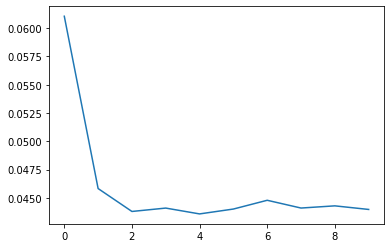

==========test==========
test total avg loss: 0.00016902107745409012
0.5451306413301663


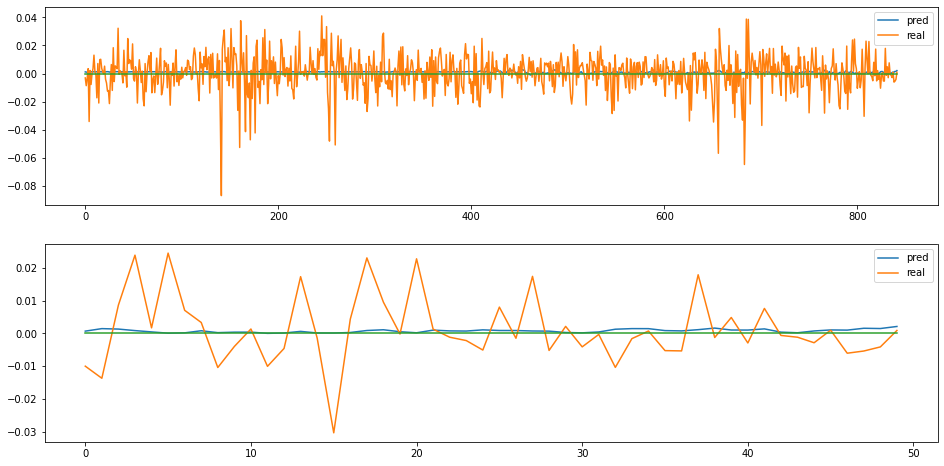

In [16]:
## LSTM

class LSTMModel(nn.Module):
    def __init__(self, embed_dim: int, seq_len: int, t2v_dim: int = 3) -> None:
        super().__init__()
        self.seq_len = seq_len
        self.num_layers = 1
        self.time2vector = Time2Vector(embed_dim, t2v_dim)
        embed_dim += t2v_dim
        
        self.lstm1 = LSTM(input_size=embed_dim, hidden_size=64,
                          num_layers=self.num_layers, batch_first=True)
        self.lstm2 = LSTM(input_size=64, hidden_size=16,
                          num_layers=self.num_layers, batch_first=True)
        self.fc1 = Linear(16 * seq_len, 25)
        self.fc2 = Linear(25, 1)

    def forward(self, x: Tensor) -> Tensor:
        t2v = self.time2vector(x)
        x = torch.cat([x, t2v], dim=2)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x.reshape((-1, 16 * self.seq_len))
        x = self.fc1(x)
        x = self.fc2(x)
        return x


model = LSTMModel(embed_dim=embed_dim, seq_len=windows_size).to(device)
criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epoch_num = 10
loss_list = train_model(model, train_dataloader, epoch_num, criterion, optimizer)
sb.lineplot(range(len(loss_list)), loss_list)
plt.show()


print('='*10 + 'test' + '='*10)


res_list = test_model(model, test_dataloader)
test_y_list = test_y.reshape(-1,)

counter = 0
for i in range(len(test_y_list)):
    if (test_y_list[i] > 0 and res_list[i] > 0) or (test_y_list[i] < 0 and res_list[i] < 0):
        counter += 1
print(counter / len(test_y_list))


fig = plt.figure(figsize=(16,8))
fig.add_subplot(2, 1, 1)
sb.lineplot(range(len(res_list)), res_list)
sb.lineplot(range(len(test_y_list)), test_y_list)
sb.lineplot(range(len(test_y_list)), [0]*len(test_y_list))
plt.legend(labels=['pred', 'real'])
fig.add_subplot(2, 1, 2)
sb.lineplot(range(50), res_list[-50:],)
sb.lineplot(range(50), test_y.reshape(-1,)[-50:],)
sb.lineplot(range(50), [0]*50)
plt.legend(labels=['pred', 'real'])

0 tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
epoch 0, total_loss_avg 0.0822620764374733
0 tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1, total_loss_avg 0.04973119869828224
0 tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2, total_loss_avg 0.04286718741059303
0 tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
epoch 3, total_loss_avg 0.039427343755960464
0 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)

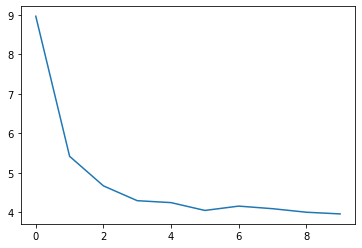

==========test==========
test total avg loss: 0.04447348788380623


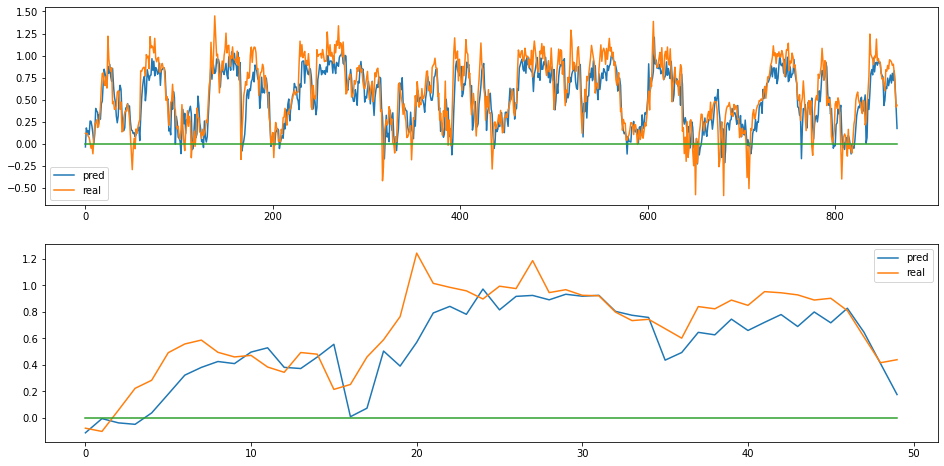

In [43]:
## 只使用归一化的收盘价

# CLOSE_SCALED = 'close_scaled'
# data[CLOSE_SCALED] = (data[CLOSE] - data_pre_30.min()) / (data_pre_30.max() - data_pre_30.min())

embed_dim = 1
data_arr = array([data[CLOSE]]).reshape((-1, embed_dim)) # -1, 1
data_x = array([data_arr[i : i + windows_size] for i in range(len(data_arr) - windows_size + 1)]) # -1, 30 ,1
data_x_max = array([max(seq) for seq in data_x])
data_x_min = array([min(seq) for seq in data_x])
data_x = array([(data_x[i] - data_x_min[i]) / (data_x_max[i] - data_x_min[i]) for i in range(len(data_x))])[:-1]
data_y = array([(data_arr[i + windows_size] - data_x_min[i] ) / (data_x_max[i] - data_x_min[i]) for i in range(len(data_arr) - windows_size)]) # -1, 1

train_data_len = int(len(data_x) * 0.8)
train_x, train_y = data_x[:train_data_len], data_y[:train_data_len]
test_x, test_y = data_x[train_data_len:], data_y[train_data_len:]

train_dataset = NdarrayDataset(train_x, train_y)
test_dataset = NdarrayDataset(test_x, test_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# model = LSTMModel(embed_dim=embed_dim, seq_len=windows_size).to(device)
model = Model(num_transformer_blocks=3, seq_len=windows_size, embed_dim=embed_dim, num_heads=3, dropout=0.1, t2v_dim=2).to(device)
criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epoch_num = 10
loss_list = train_model(model, train_dataloader, epoch_num, criterion, optimizer)
sb.lineplot(range(len(loss_list)), loss_list)
plt.show()


print('='*10 + 'test' + '='*10)


res_list = test_model(model, test_dataloader)
test_y_list = test_y.reshape(-1,)

fig = plt.figure(figsize=(16,8))
fig.add_subplot(2, 1, 1)
sb.lineplot(range(len(res_list)), res_list)
sb.lineplot(range(len(test_y_list)), test_y_list)
sb.lineplot(range(len(test_y_list)), [0]*len(test_y_list))
plt.legend(labels=['pred', 'real'])
fig.add_subplot(2, 1, 2)
sb.lineplot(range(50), res_list[-50:],)
sb.lineplot(range(50), test_y.reshape(-1,)[-50:],)
sb.lineplot(range(50), [0]*50)
plt.legend(labels=['pred', 'real'])